In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"device: {device}")
torch.set_default_device(device)

device: mps


In [3]:
from module.conf import PROJECT_DIR
import struct
from array import array 

mnist_path = "/data/sample/mnist"
training_images_filepath = "".join([PROJECT_DIR, mnist_path, "/train-images.idx3-ubyte"])
training_labels_filepath = "".join([PROJECT_DIR, mnist_path, "/train-labels.idx1-ubyte"])
test_images_filepath = "".join([PROJECT_DIR, mnist_path, "/t10k-images.idx3-ubyte"])
test_labels_filepath = "".join([PROJECT_DIR, mnist_path, "/t10k-labels.idx1-ubyte"])

def read_images_labels(images_filepath, labels_filepath) -> tuple:
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        # labels = array("B", file.read())
        labels = array("B", file.read())

    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())

    images = []
    # for i in range(size):
    #     images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        # images[i][:] = img
        images.append(img)

    return images, labels

def load_data() -> ((np.ndarray, np.ndarray),(np.ndarray, np.ndarray)):
    x_train, y_train = read_images_labels(training_images_filepath, training_labels_filepath)
    x_test, y_test = read_images_labels(test_images_filepath, test_labels_filepath)
    return (np.array(x_train, dtype=np.float32), np.array(y_train)),(np.array(x_test, dtype=np.float32), np.array(y_test))

(X_train, y_train), (X_test, y_test) = load_data()
# X_train, X_test = X_train / 255.0, X_test / 255.0

In [4]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, img_dim=784):  # 28*28=784 fors MNIST
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [5]:
# random noise vector
noise_dim = 100

# init Generator and Discriminator
gen = Generator(noise_dim).to(device=device)
disc = Discriminator().to(device=device)

# loss and optimizers
criterion = nn.BCELoss().to(device=device)
optimizer_gen = optim.Adam(gen.parameters(), lr=0.0002)
optimizer_disc = optim.Adam(disc.parameters(), lr=0.0002)

In [6]:
from torch.utils.data import Dataset


class TransformedTensorDataset(Dataset):
    def __init__(self, tensor_dataset, transform=None):
        self.tensor_dataset = tensor_dataset
        self.transform = transform
    def __len__(self):
        return len(self.tensor_dataset)
    def __getitem__(self, idx):
        sample, label = self.tensor_dataset[idx]
        if self.transform:
            sample = self.transform(sample)
            pass
        return sample, label

In [7]:
from torchvision.transforms import v2
transform = v2.Compose([
    # v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5,), (0.5,))  # Normalization to [-1, 1]
])

# dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=False)
train, test = torch.from_numpy(X_train).float()/127.5 - 1, torch.from_numpy(y_train).int()
# dataloader = DataLoader((train, test), batch_size=64, shuffle=True, generator=torch.Generator(device=device))
dataset = torch.utils.data.TensorDataset(train, test)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, generator=torch.Generator(device=device))
# dataloader = TransformedTensorDataset(dataset, transform=transform)

In [8]:
def train_gan_1():
    num_epochs = 20 #50
    for epoch in range(num_epochs):
        for batch_idx, (real, _) in enumerate(dataloader):
            batch_size = real.size(0)   # batch_size
            real: torch.Tensor = real.view(batch_size, -1).to(device=device)    # reshape
            
            # Labels for real and fake
            labels_real = torch.ones(batch_size, 1).to(device=device)
            labels_fake = torch.zeros(batch_size, 1).to(device=device)
    
            # train Discriminator for real
            disc_real: torch.Tensor = disc(real)
            loss_disc_real: torch.Tensor = criterion(disc_real, labels_real)
    
            # train Discriminator for fake
            noise = torch.randn(batch_size, noise_dim)
            fake_images: torch.Tensor = gen(noise)
            disc_fake: torch.Tensor = disc(fake_images.detach())
            loss_disc_fake: torch.Tensor = criterion(disc_fake, labels_fake)
    
            # total loss of Discriminator
            loss_disc: torch.Tensor = (loss_disc_real + loss_disc_fake) # / 2
            # loss_disc: torch.Tensor = -disc_real + loss_disc_fake
            optimizer_disc.zero_grad()
            loss_disc.backward()
            optimizer_disc.step()
    
            # train Generator to fool Discriminator
            output = disc(fake_images)
            loss_gen = criterion(output, labels_real)
            optimizer_gen.zero_grad()
            loss_gen.backward()
            optimizer_gen.step()
    
        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")
# train_gan_1()

In [9]:
def train_gan_2():
    num_epochs = 20 #50
    for epoch in range(num_epochs):
        for batch_idx, (real, _) in enumerate(dataloader):
            batch_size = real.size(0)   # batch_size
            real: torch.Tensor = real.view(batch_size, -1).to(device=device)    # reshape

            # Labels for real and fake
            labels_real = torch.ones(batch_size, 1).to(device=device)
            labels_fake = torch.zeros(batch_size, 1).to(device=device)

            # train Discriminator for real
            optimizer_disc.zero_grad()
            disc_real: torch.Tensor = disc(real)
            loss_disc_real: torch.Tensor = criterion(disc_real, labels_real)
            # loss_disc_real.backward()

            # train Discriminator for fake
            noise = torch.randn(batch_size, noise_dim)
            fake_images: torch.Tensor = gen(noise)
            disc_fake: torch.Tensor = disc(fake_images.detach())
            loss_disc_fake: torch.Tensor = criterion(disc_fake, labels_fake)
            # loss_disc_fake.backward()
            # optimizer_disc.step()
            
            # total loss of Discriminator
            loss_disc: torch.Tensor = (loss_disc_real + loss_disc_fake) # / 2
            loss_disc.backward()
            optimizer_disc.step()
            
            # train Generator to fool Discriminator
            optimizer_gen.zero_grad()
            output = disc(fake_images)
            loss_gen = criterion(output, labels_real)
            loss_gen.backward()
            optimizer_gen.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")
train_gan_2()

Epoch [1/20] | Loss D: 0.6866, Loss G: 3.1212
Epoch [2/20] | Loss D: 0.1850, Loss G: 4.9780
Epoch [3/20] | Loss D: 0.8712, Loss G: 2.1829
Epoch [4/20] | Loss D: 0.7557, Loss G: 3.6684
Epoch [5/20] | Loss D: 0.4253, Loss G: 3.4836
Epoch [6/20] | Loss D: 0.2902, Loss G: 4.2003
Epoch [7/20] | Loss D: 0.3230, Loss G: 2.7840
Epoch [8/20] | Loss D: 0.5913, Loss G: 2.2437
Epoch [9/20] | Loss D: 1.0675, Loss G: 1.9205
Epoch [10/20] | Loss D: 0.7381, Loss G: 1.8340
Epoch [11/20] | Loss D: 0.6529, Loss G: 1.7063
Epoch [12/20] | Loss D: 0.7143, Loss G: 1.4830
Epoch [13/20] | Loss D: 0.6048, Loss G: 1.6239
Epoch [14/20] | Loss D: 0.9751, Loss G: 1.3673
Epoch [15/20] | Loss D: 0.7690, Loss G: 1.3700
Epoch [16/20] | Loss D: 0.8138, Loss G: 1.5636
Epoch [17/20] | Loss D: 0.6728, Loss G: 2.1492
Epoch [18/20] | Loss D: 0.8801, Loss G: 1.7040
Epoch [19/20] | Loss D: 0.9300, Loss G: 1.9465
Epoch [20/20] | Loss D: 0.9749, Loss G: 1.2398


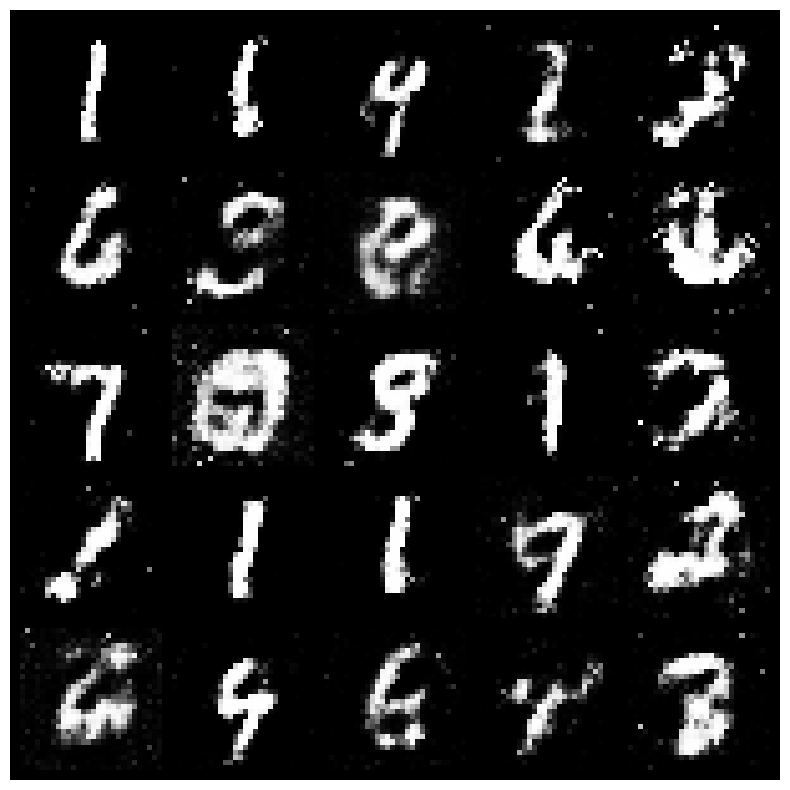

In [19]:
def generate_and_plot_images(generator, noise_dim, num_images=25):
    noise = torch.randn(num_images, noise_dim)
    fake_images = generator(noise).view(-1, 1, 28, 28)
    fake_images = (fake_images ) / 2 + 0.5 # scale to [0, 1]

    grid = torchvision.utils.make_grid(fake_images, nrow=5)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid.detach().cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()

# generate
generate_and_plot_images(gen, noise_dim)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Thiết lập seed
torch.manual_seed(0)

# Cấu trúc Generator
class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 1),  # Đầu ra là một giá trị
        )

    def forward(self, x):
        return self.model(x)

# Cấu trúc Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),  # Đầu ra là giá trị không bị giới hạn
        )

    def forward(self, x):
        return self.model(x)

# Hàm huấn luyện WGAN
def train_wgan(generator, discriminator, num_epochs=1000, batch_size=64, noise_dim=10):
    d_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.00005)
    g_optimizer = optim.RMSprop(generator.parameters(), lr=0.00005)

    for epoch in range(num_epochs):
        for _ in range(5):  # Huấn luyện Discriminator nhiều lần
            # Tạo dữ liệu thật từ phân phối chuẩn
            real_data = torch.randn(batch_size, 1) * 0.5 + 2  # Giả sử dữ liệu thật đến từ phân phối N(2, 0.5)

            # Tạo noise cho Generator
            noise = torch.randn(batch_size, noise_dim)

            # Đầu ra từ Generator
            fake_data = generator(noise)

            # Tính toán giá trị Discriminator cho dữ liệu thật và giả
            d_loss_real = discriminator(real_data)
            d_loss_fake = discriminator(fake_data)

            # Tính toán Wasserstein Loss
            d_loss = -torch.mean(d_loss_real) + torch.mean(d_loss_fake)

            # Cập nhật Discriminator
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Clip trọng số của Discriminator để đảm bảo tính khả thi
            for p in discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)

        # Huấn luyện Generator
        noise = torch.randn(batch_size, noise_dim)
        fake_data = generator(noise)
        g_loss = -torch.mean(discriminator(fake_data))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

# Khởi tạo mô hình
generator = Generator(input_dim=10)
discriminator = Discriminator()

# Huấn luyện WGAN
train_wgan(generator, discriminator)

# Vẽ kết quả
z = torch.randn(1000, 10)
fake_samples = generator(z).detach().numpy()
plt.hist(fake_samples, bins=30, alpha=0.5, color='orange')
plt.title("Generated Samples")
plt.show()

Epoch [0/1000], d_loss: -0.0004, g_loss: -0.0092
Epoch [100/1000], d_loss: -0.0004, g_loss: -0.0054
Epoch [200/1000], d_loss: 0.0001, g_loss: -0.0106
Epoch [300/1000], d_loss: -0.0000, g_loss: -0.0073
Epoch [400/1000], d_loss: 0.0000, g_loss: -0.0080
Epoch [500/1000], d_loss: 0.0000, g_loss: -0.0067
Epoch [600/1000], d_loss: 0.0000, g_loss: -0.0076
Epoch [700/1000], d_loss: -0.0000, g_loss: -0.0073
Epoch [800/1000], d_loss: -0.0001, g_loss: -0.0063
Epoch [900/1000], d_loss: -0.0001, g_loss: -0.0075


TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.